# Final Project, Part 4: Technical Notebook

_**Requirements:** Statistical analysis, model, evaluation metrics; don't forget: sample size, correlations, feature importance, unexplained variance or outliers, variable selection, train/test comparison, relationships between target and independent variables._

## Recap

Out of the many features available for us to explore, exploratory data analysis led us to narrow the features down to the **six** below. Including all the available features introduced too much collinearity and each unique feature combination became too small to easily calculate any sort of statistical significance.

By narrowing down the number of features examined, we are definitely leaving out interesting influences like _datetime_, _detailed content relevance_, _user demographics_. Unfortunately, these more interesting investigations will need to be left for a future time. 

With the features below, we can still identify valuable takeaways as which creative sizes, _which platforms (desktop or mobile)_, _which sites_, and _where on the page_ an ad is mostly likely to generate a click. 

|Creative||User||Context|
|------||------||------|
|Creative Size||Device Category||Ad Unit 1 (domain)|
|Line Item Type||||Ad Unit 3 (placement)|
|Advertiser/Order|||||

Of the six features above, we also discovered **collinearity**. Namely, **Ad Unit 1** and **Ad Unit 3** both have **Device Category** confounded within them.

## Which Model?

### Our Data

- number of rows
- average ctr

Interesting characteristics:
- binary results, click or no click
- feature conjunction (it's often a combination of two feature values that make a difference, like Advertiser vs Ad Unit 1. Behr paints ad works better next to Paint content.)
- Categorical variables (Ad Unit 1 has X unique values, with no hierarchical order.) 

Binary results indicate **Logistic Regression** class of models. 

### Industry Insights

Fortunately for us, digital advertising is a lucrative __[$584 billion global business](http://www.dentsuaegisnetwork.com/media/dentsuaegisnetworknewsdetaila/2017/2017_06_15?Global-ad-spend-to-hit-5634-billion-in-2017-with-digital-driving-growth)__, so many smart people have already tried predicting CTR. 

#### __["Simple and scalable response prediction for display advertising"](http://people.csail.mit.edu/romer/papers/TISTRespPredAds.pdf)__  (Chapelle, Manavoglu, Rosales; 2015)
- **Methods:** Logistic Regression, Feature Hashing, Subsampling, L1 regularization
- **Evaluation Metrics:** auROC

#### __["Outbrain Click Prediction"](http://cs229.stanford.edu/proj2016/report/JaiswalGopinathLimaye-OutbrainClickPrediction-report.pdf)__ (Limaye, Jaiswal, Gopinath; 2016)
- **Methods:** One hot encoding, feature engineering for conjugate features, factorization machines, boosted trees model
- **Evaluation Metrics:** MAP@12

#### __["3 Idiots' Solution to 2014 Criteo Display Advertising Kaggle Challenge"](https://www.kaggle.com/c/criteo-display-ad-challenge/discussion/10555)__
- **Methods:** field-aware factorizatiom machines
- **Evaluation Metrics:** MAP@12

#### __["How Feature Engineering can help you do well in a Kaggle competition - Part I"](https://medium.com/unstructured/how-feature-engineering-can-help-you-do-well-in-a-kaggle-competition-part-i-9cc9a883514d)__
- **Methods:** One hot encoding, feature hashing, gradient boosted decision trees, logistic regression with Follow-the-Regularized-Leader (FTRL) optimizer, Field-aware Factorization Machines, Ensembling
- **Evaluation Metrics:** MAP@12

__[Other](https://www.slideshare.net/gabrielspmoreira/feature-engineering-getting-most-out-of-data-for-predictive-models)__ feature engineering options:
- bin-counting
- LabelCount encoding
- Category embedding
- Support Vector Machines (SVM) - new model


### Initial Approach

1. Set evaluation metrics.
1. Split train/test data set.
2. Set baseline "model".
3. One-hot encoding/feature hashing.
4. Logistic regression w/ FTRL optimization.
5. Try Field-aware Factorization Machines. 
6. Try Ensembling.

***

## Evaluation Metrics

There are several evaluation metrics that can be used with logistic regression models. (MSE, R^2 and other regression metrics _aren't_ appropriate for this categorical classification model.)

- <font color=blue>**Confusion Matrix**: We care about correctly predicting clicks and care less about predicting non-clicks (they don't make us money). We'd also rather err on the side of conservation and let a click pass than to predict a click that doesn't happen; it is better to underpromise and overdeliver on a CTR estimate to a client.</font>

- **Mean Average Precision (MAP)**: New evaluation metric we haven't explored in class that is derived from the confusion matrix. 

- **Receiver Operating Characteristic (ROC) curve**: Graph of a model's sensitivity (true positive rate) against its specificity (true negative rate). The more convex the curve is, the better.

- <font color=blue> **Area Under Curve (AUC)**: "Area under the ROC curve" - a way of quantifying the ROC. A poor classifier has an AUC of 0.5; the best ones have an AUC as close to 1 as possible.</font>

- **Log Loss**: Quantifies unpredictability of your model. The goal is to minimize this value.

Since several Kaggle competitions have used **MAP@12**, I will use this evaluation metric as well. However, I plan on playing around with optimizing by Log Loss and AUC, too, if they somehow lead to a better model.

<p><font color=blue>_**EDIT:** I couldn't find an easy-to-implement MAP metric in sklearn, so went with sklearn's standard accuracy score instead. Secondarily, I also looked at **re-call** and **precision** in the confusion matrix._</font>

<font color=blue>Creating a list to store all the accuracy, AUROC and recall scores.</font>

In [422]:
final_scores = []

In [421]:
def add_score(model_name,accuracy,AUROC,recall):    
    test_model = {
        'model_name': model_name,
        'accuracy': accuracy,
        'AUROC': AUROC,
        'recall': recall
    }
    final_scores.append(test_model)
    return final_scores

## Train/Test Sets

Before I proceed, just want to confirm we have enough data to use **three-way split**.

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [108]:
df = pd.read_csv('../FinalProject_EDA_v2/final_df.csv')

In [1]:
#df.head()

In [110]:
df = df.iloc[:,1:].reset_index(drop=True)

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4704 entries, 0 to 4703
Data columns (total 15 columns):
impressions         4704 non-null float64
clicks              4704 non-null float64
ad_unit_1           4704 non-null object
ad_unit_3           4507 non-null object
line_item_type      4704 non-null object
order               4704 non-null object
creative_size       4704 non-null object
CTR                 4704 non-null float64
null_ctr            4704 non-null float64
ctr_diff            4704 non-null float64
size_grouped        4704 non-null object
device_category     4704 non-null object
ad_unit_1_clean     4704 non-null object
ad_unit_3_device    4507 non-null object
ad_unit_1_order     4704 non-null object
dtypes: float64(5), object(10)
memory usage: 551.3+ KB


In [112]:
print df['impressions'].sum()
print df['clicks'].sum()

print df['impressions'].sum()/4704
print df['clicks'].sum()/4704

235332097.0
494645.0
50028.0818452
105.15412415


Hm… we average out to just 105 clicks per row. I'm not really sure how concerning this is. It seems like a very small number. I'll move forward in the meantime.

In [113]:
print 4704*0.2 
# how many rows will be in the test dataset if 80/20 split.

940.8


In [114]:
df.columns

Index([u'impressions', u'clicks', u'ad_unit_1', u'ad_unit_3',
       u'line_item_type', u'order', u'creative_size', u'CTR', u'null_ctr',
       u'ctr_diff', u'size_grouped', u'device_category', u'ad_unit_1_clean',
       u'ad_unit_3_device', u'ad_unit_1_order'],
      dtype='object')

In [115]:
feature_cols = ['line_item_type',
                'ad_unit_1_order',
                'size_grouped',
                'ad_unit_3_device',
                'device_category',
                'ad_unit_1_clean'
               ]

In [196]:
X = df[feature_cols]
y = df['y']

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.20)

***

## One-Hot Encoding

Before I can run anything through models, need to convert my categorical variables into numerical ones. I'll try both One-Hot Encoding and Feature Hashing and see how performance compares.

One-Hot is basically like get_dummies, so I'll just do that. __[(source)](https://stackoverflow.com/questions/36631163/pandas-get-dummies-vs-sklearns-onehotencoder-what-is-more-efficient)__

In [116]:
feature_cols

['line_item_type',
 'ad_unit_1_order',
 'size_grouped',
 'ad_unit_3_device',
 'device_category',
 'ad_unit_1_clean']

In [1]:
#df.head()

In [118]:
df_dummies = df

In [2]:
#df_dummies.join(pd.get_dummies(df_dummies['line_item_type'],drop_first=True, prefix='line_item_type-'))

In [120]:
for col in feature_cols[1:]:
    df_dummies = df_dummies.join(pd.get_dummies(df_dummies[col],drop_first=True, prefix=col+'-'))

In [3]:
#df_dummies.head()

In [4]:
#list(df_dummies.columns)

In [123]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4704 entries, 0 to 4703
Columns: 464 entries, impressions to ad_unit_1_clean-_The Spruce
dtypes: float64(5), object(10), uint8(449)
memory usage: 2.6+ MB


Now there are 4704 rows and 464 columns.

***

## Logistic Regression with CTR Binning

This method bins CTR into just two binary categories, so we can use logistic regression per usual.

### Bin CTRs

1. Look at distribution, decide where to bin.
2. Bin the CTRs.

#### 1. Decide where to set bin cutoff.

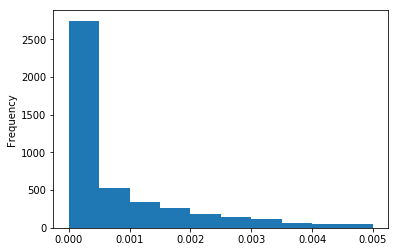

In [124]:
df_dummies['CTR'].plot(kind='hist', range=[0, 0.005])

In [125]:
df_dummies['CTR'].describe()

count    4704.000000
mean        0.002104
std         0.014702
min         0.000000
25%         0.000000
50%         0.000198
75%         0.001359
max         0.500000
Name: CTR, dtype: float64

Because these CTRs are not weighted by impression volume, there are a lot of outliers. 

Removing all CTRs where impressions are <10,000 to see how that affects the distribution.

In [126]:
df_dummies[(df_dummies['impressions'] > 10000)]['CTR'].describe()

count    1343.000000
mean        0.001609
std         0.002772
min         0.000000
25%         0.000394
50%         0.001031
75%         0.002128
max         0.081592
Name: CTR, dtype: float64

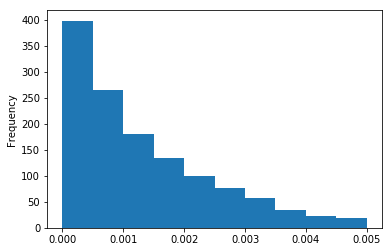

In [127]:
df_dummies[(df_dummies['impressions'] > 10000)]['CTR'].plot(kind='hist',range=[0, 0.005])

Interesting, removing low volume impression rows not only removed high-value outliers, they also removed a lot of 0% CTR rows.

Taking the **median** as our bin cutoff, we would split at 0.10% CTR.

Industry benchmarks from __[Google](http://www.richmediagallery.com/learn/benchmarks)__ have all US display media averaging between 0.07%-0.09% CTR. 

This is roughly in-line with the median we see in our data. (It's promising that our mean is a good chunk above the industry average, at 0.16%.) 

So, we'll use **0.10%** as the cutoff for our binary "good/bad" CTR values.

#### 2. Categorize CTRs.

In [128]:
df_dummies['ctr_bin'] = np.where(df['CTR']>=0.0010,1,0)

In [129]:
df_dummies['ctr_bin'].value_counts()

0    3278
1    1426
Name: ctr_bin, dtype: int64

### Run a null model

Just to level set, the "null" percentage I get from summing the count of 1s in "ctr_bin" is saying, "With no information other than the training data results—no knowledge about any factors effect on CTR, etc—our best guess as to what makes a good/bad CTR and how many good/bad CTRs would be in a data set is just whatever the percentage of "good CTR" make up this training dataset."

In [130]:
y_null = sum(df_dummies['ctr_bin'])/float(len(df.index))
y_null

0.30314625850340138

### Train test split data new, since Y variable is now ctr_bin.

In [5]:
#df_dummies.columns[15:464]

In [132]:
feature_cols2 = df_dummies.columns[15:464]

In [133]:
X = df_dummies[feature_cols2]
y = df_dummies['ctr_bin']

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.2)

Leave CV to LogisticRegressionCV() function in optimization section?

### Run an actual model

In [135]:
logreg = linear_model.LogisticRegression()

In [136]:
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [423]:
y_pred = logreg.predict(X_train)
logreg.score(X_train,y_train)

0.83151740632474092

**Before:** Our model was 80% accurate on training data.

**After adding in order-ad_unit_1 interactive feature:** Our model is now at 83% accuracy.

In [424]:
y_pred = logreg.predict(X_test)
acc = logreg.score(X_test,y_test)
print acc

0.778958554729


**Before**: Our model was 76% accurate on the test data.

**After adding in order-ad_unit_1 interactive feature:** Our model is now at 78% accuracy.

### Calculate AUROC Score

In [426]:
auroc = metrics.roc_auc_score(
    y_true=y_test,
    y_score=y_pred,
    average=None
)
auroc

0.70899796481582122

### Calculate Confusion Matrix

In [427]:
metrics.confusion_matrix(
    y_true=y_test,
    y_pred=y_pred
)

array([[581,  73],
       [135, 152]])

In [428]:
print metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred
)

             precision    recall  f1-score   support

          0       0.81      0.89      0.85       654
          1       0.68      0.53      0.59       287

avg / total       0.77      0.78      0.77       941



In [429]:
recall = metrics.recall_score(
    y_true=y_test,
    y_pred=y_pred
)
recall

0.52961672473867594

In [430]:
# add_score(model_name,accuracy,AUROC,recall)
add_score('LogReg_Bin',acc,auroc,recall)

[{'AUROC': 0.70899796481582122,
  'accuracy': 0.77895855472901165,
  'model_name': 'LogReg_Bin',
  'recall': 0.52961672473867594}]

<font color=blue>**Follow-Up:** To account for unbalanced data sets, apply weighting to down-sample/balance out the data.</font>

### <font color=blue>Run balanced model</font>

In [431]:
logreg_bal = linear_model.LogisticRegression(
    class_weight='balanced'
)

In [432]:
logreg_bal.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [433]:
y_pred = logreg_bal.predict(X_train)
logreg_bal.score(X_train,y_train)

0.79883072017007706

In [434]:
y_pred = logreg_bal.predict(X_test)
acc = logreg_bal.score(X_test,y_test)
acc

0.73113708820403822

So overall model accuracy went from 76% down to 73%, but ideally our recall and precision increased.

### Calculate AUROC Score

In [436]:
auroc = metrics.roc_auc_score(
    y_true=y_test,
    y_score=y_pred,
    average=None
)
auroc

0.73227471789789966

Nice, AUROC went up from 70% to 73%, so overall unpredictability decreased.

### Calculate Confusion Matrix

In [437]:
metrics.confusion_matrix(
    y_true=y_test,
    y_pred=y_pred
)

array([[477, 177],
       [ 76, 211]])

In [438]:
print metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred
)

             precision    recall  f1-score   support

          0       0.86      0.73      0.79       654
          1       0.54      0.74      0.63       287

avg / total       0.77      0.73      0.74       941



**Recall** is better, more balanced, but precision is less balanced. We care about fewer false negatives, so recall is more relevant, anyway.

In [439]:
recall = metrics.recall_score(
    y_true=y_test,
    y_pred=y_pred
)
recall

0.73519163763066198

In [440]:
# add_score(model_name,accuracy,AUROC,recall)
add_score('LogReg_Bin_Bal',acc,auroc,recall)

[{'AUROC': 0.70899796481582122,
  'accuracy': 0.77895855472901165,
  'model_name': 'LogReg_Bin',
  'recall': 0.52961672473867594},
 {'AUROC': 0.73227471789789966,
  'accuracy': 0.73113708820403822,
  'model_name': 'LogReg_Bin_Bal',
  'recall': 0.73519163763066198}]

### What do the coefficients mean?

In [151]:
coefficients = []

In [152]:
for each in logreg.coef_[0]:
    coefficients.append(each)

In [153]:
len(coefficients)

449

In [154]:
#logreg.coef_[0]

In [155]:
features_list = list(feature_cols2)

In [156]:
len(features_list)

449

#### Convert coefficient values to logodds

In [157]:
def logodds_to_prob(x):
    logodds = x
    odds = np.exp(logodds)
    prob = odds/(1+odds)
    return prob

In [158]:
prob = logodds_to_prob(coefficients)

#### Combine into a dataframe

In [159]:
feat_coef = pd.DataFrame(
{
    'feature': features_list,
    'coef': coefficients,
    'prob': prob
})

In [6]:
#feat_coef.sort_values(by='coef',ascending=False).head(10)

In [7]:
#feat_coef.sort_values(by='coef',ascending=False).tail(10)

The intuition here is a little weird. A -2.445 logodds still converts to a positive probability, when in reality that features hould probably be decreasing probability… Or perhaps it's anything underneath a threshold (since our values are always between 0 and 1).

Looks like specific **creatives (orders)** and **placements** make the biggest impact:
- **728x90** perofrms really badly; don't recommend this creative size.
- You also don't want to place any of the ads **below-the-fold** (these are the billboard5s and billboard6s).

This makes me wonder if I should have actually paired ad placement and device category together, as well as creative and ad_unit_1, and then removed device category all together.

**Results:** Tried the above, adding both columns (and removing their old non-paired counterparts to avoid unnecessary collinearity) increases model accuracy by a good 2-3%.

### Optimize by tuning C + adding CV (GridSearchCV)

h/t Chris Albon

In [162]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [163]:
# Create grid search using 10-fold cross validation
clf = GridSearchCV(logreg, hyperparameters, cv=10, verbose=0)

In [164]:
# Fit grid search
best_model = clf.fit(X_train, y_train)

In [165]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best Parameter', best_model.best_params_)

('Best Penalty:', 'l2')
('Best C:', 2.7825594022071245)
('Best Parameter', {'penalty': 'l2', 'C': 2.7825594022071245})


In [166]:
# Predict target vector
y_pred = best_model.predict(X_train)

In [167]:
print best_model.best_score_
print best_model.best_estimator_

0.782088758969
LogisticRegression(C=2.7825594022071245, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


<font color=blue>**Note:** Couldn't figure out how to get AUROC or recall scores from the best estimator, so replicating GridSearchCV with LogisticRegressionCV.</font>

### Replicate using LogisticRegressionCV()

In [168]:
logreg_cv = linear_model.LogisticRegressionCV(
    Cs=[2.7825594022071245],
    class_weight='balanced',
    dual=False,
    fit_intercept=True,
    intercept_scaling=1,
    max_iter=100,
    multi_class='ovr',
    n_jobs=1,
    penalty='l2',
    random_state=None,
    solver='liblinear',
    tol=0.0001,
    verbose=0,
    cv=10
)

In [169]:
logreg_cv.fit(X_train,y_train)

LogisticRegressionCV(Cs=[2.7825594022071245], class_weight='balanced', cv=10,
           dual=False, fit_intercept=True, intercept_scaling=1,
           max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='liblinear',
           tol=0.0001, verbose=0)

In [441]:
y_pred = logreg_cv.predict(X_train)
logreg_cv.score(X_train,y_train)

0.81264948179643903

Best performance against test data.

In [442]:
y_pred = logreg_cv.predict(X_test)
acc = logreg_cv.score(X_test,y_test)
acc

0.74814027630180657

In [443]:
metrics.average_precision_score(
    y_true=y_test, 
    y_score=y_pred, 
    average=None
)

0.50101306061398732

In [444]:
auroc = metrics.roc_auc_score(
    y_true=y_test,
    y_score=y_pred,
    average=None
)
auroc

0.74939530522434983

More slight improvement!

### Calculate Confusion Matrix

In [445]:
metrics.confusion_matrix(
    y_true=y_test,
    y_pred=y_pred
)

array([[488, 166],
       [ 71, 216]])

In [446]:
print metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred
)

             precision    recall  f1-score   support

          0       0.87      0.75      0.80       654
          1       0.57      0.75      0.65       287

avg / total       0.78      0.75      0.76       941



Recall is more balanced, precision still not so much.

In [447]:
recall = metrics.recall_score(
    y_true=y_test,
    y_pred=y_pred
)
recall

0.7526132404181185

In [448]:
# add_score(model_name,accuracy,AUROC,recall)
add_score('LogReg_Bin_Bal_GSCV',acc,auroc,recall)

[{'AUROC': 0.70899796481582122,
  'accuracy': 0.77895855472901165,
  'model_name': 'LogReg_Bin',
  'recall': 0.52961672473867594},
 {'AUROC': 0.73227471789789966,
  'accuracy': 0.73113708820403822,
  'model_name': 'LogReg_Bin_Bal',
  'recall': 0.73519163763066198},
 {'AUROC': 0.74939530522434983,
  'accuracy': 0.74814027630180657,
  'model_name': 'LogReg_Bin_Bal_GSCV',
  'recall': 0.7526132404181185}]

### Coefficients Exploration

In [174]:
coefficients = []
for each in logreg_cv.coef_[0]:
    coefficients.append(each)

In [175]:
features_list = list(feature_cols2)

In [176]:
prob = logodds_to_prob(coefficients)

In [177]:
feat_coef = pd.DataFrame(
{
    'feature': features_list,
    'coef': coefficients,
    'prob': prob
})

In [9]:
#feat_coef.sort_values(by='coef',ascending=False).head(20)

In [8]:
#feat_coef.sort_values(by='coef',ascending=False).tail(20)

There hasn't been any actual ranking change, even as the model has improved.

## Multinomial Logistic Regression with CTR Binning

Another method recommended by a data scientist coworker is binning CTRs into high, medium, low ranges. Since our goal is to understand which features most influence higher CTR, it's not necessary for us to know exactly what the end CTR is or to predict a specific CTR.

This should be just like the binomial logistic regression above, just with more bins. I imagine it would have higher model performance, since it's more granular? (As long as there isn't too much overfitting.)

### 1. Bin the CTRs

Going to split CTRs into 3 vs 4 vs 5 categories and see how that affects performance.

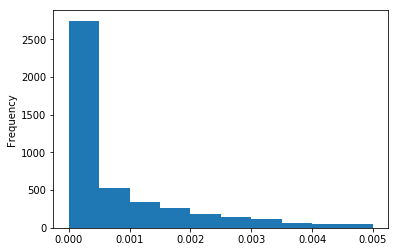

In [180]:
df_dummies['CTR'].plot(kind='hist', range=[0, 0.005])

In [181]:
print df_dummies['CTR'].count()/3
print df_dummies['CTR'].count()/3*2
print df_dummies['CTR'].count()

1568
3136
4704


In [182]:
df_ctr = df_dummies['CTR'].sort_values(ascending=True).reset_index(drop=True)

In [183]:
print df_ctr[1568]
print df_ctr[3136]
print df_ctr[4703]

0.0
0.000853533629225
0.5


In [184]:
def binner(num):
    for each in range(0,num):
        bin = df_dummies['CTR'].count()/num*each
        print df_ctr[bin]
    print df_ctr[4703]

In [185]:
binner(4)

0.0
0.0
0.000199215719169
0.00135961930659
0.5


In [186]:
binner(5)

0.0
0.0
0.0
0.00055277269016
0.00173310225303
0.5


Not sure how the unbalanced nature of the dataset is going to affect model performance. Actually seems like the only reasonable bin is using 3 groups: 
- [0,0.000199215719169)
- [0.000199215719169,0.00135961930659)
- [0.00135961930659,0.5]

I have a feeling this model is actually going to be poorer than the previous, because that final bucket is going to be heavily skewed by outliers… 

**Weight of evidence (WOE)** could be an interesting way of binning and measuring my caetgorical dependent variables… __[link](http://multithreaded.stitchfix.com/blog/2015/08/13/weight-of-evidence/)__

#### 2. Categorize the CTRs.

In [187]:
bins = [-0.00000000000001, 0.000199215719169, 0.00135961930659, 0.5]

In [188]:
group_names = ['low','good','great']

In [189]:
ctr_bins = pd.cut(df_dummies['CTR'], bins, labels=group_names)
ctr_bins.value_counts()

low      2352
good     1177
great    1175
Name: CTR, dtype: int64

In [190]:
df_dummies['ctr_bins'] = pd.cut(df_dummies['CTR'], bins, labels=group_names)

In [10]:
#df_dummies.head()

### Null model

Is still the same as null model from binomial logistic regression.

### Reassign y value, but train/test/split sets still remain the same.

In [194]:
y = df_dummies['ctr_bins']

### Run an actual model

In [196]:
multilogreg = linear_model.LogisticRegression(multi_class='multinomial', class_weight='balanced', solver='newton-cg')

In [197]:
multilogreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

Multinomial regression doesn't accept the best solver from the previous model, **liblinear**. A bit over my head, so just switching to a solver that works.

In [449]:
y_pred = multilogreg.predict(X_train)
multilogreg.score(X_train,y_train)

0.80972628222163168

Ooh, this model is a *bit* better than the binomial linear regression against the training data.

In [450]:
y_pred = multilogreg.predict(X_test)
acc = multilogreg.score(X_test,y_test)
acc

0.73751328374070135

Same with test data.

#### AUC Score

In [452]:
auroc = metrics.roc_auc_score(
    y_true=y_test,
    y_score=y_pred,
    average=None
)
auroc

0.73588423957634075

Improvements across all metrics. Now to optimize again.

### Calculate Confusion Matrix

In [453]:
metrics.confusion_matrix(
    y_true=y_test,
    y_pred=y_pred
)

array([[484, 170],
       [ 77, 210]])

In [454]:
print metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred
)

             precision    recall  f1-score   support

          0       0.86      0.74      0.80       654
          1       0.55      0.73      0.63       287

avg / total       0.77      0.74      0.75       941



No real difference to precision and recall.

In [455]:
recall = metrics.recall_score(
    y_true=y_test,
    y_pred=y_pred
)
recall

0.73170731707317072

In [456]:
# add_score(model_name,accuracy,AUROC,recall)
add_score('LogReg_Multi',acc,auroc,recall)

[{'AUROC': 0.70899796481582122,
  'accuracy': 0.77895855472901165,
  'model_name': 'LogReg_Bin',
  'recall': 0.52961672473867594},
 {'AUROC': 0.73227471789789966,
  'accuracy': 0.73113708820403822,
  'model_name': 'LogReg_Bin_Bal',
  'recall': 0.73519163763066198},
 {'AUROC': 0.74939530522434983,
  'accuracy': 0.74814027630180657,
  'model_name': 'LogReg_Bin_Bal_GSCV',
  'recall': 0.7526132404181185},
 {'AUROC': 0.73588423957634075,
  'accuracy': 0.73751328374070135,
  'model_name': 'LogReg_Multi',
  'recall': 0.73170731707317072}]

### Coefficients Exploration

In [208]:
coefficients = []
for each in multilogreg.coef_[0]:
    coefficients.append(each)

In [209]:
features_list = list(feature_cols2)

In [210]:
prob = logodds_to_prob(coefficients)

In [211]:
feat_coef = pd.DataFrame(
{
    'feature': features_list,
    'coef': coefficients,
    'prob': prob
})

In [11]:
#feat_coef.sort_values(by='coef',ascending=False).head(20)

In [12]:
#feat_coef.sort_values(by='coef',ascending=False).tail(20)

Best and worst features are basically the same against previous model.

### Optimize by tuning C (GridSearch) + adding CV again

In [202]:
# Create regularization penalty space
penalty = ['l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [203]:
# Create grid search using 10-fold cross validation
clf = GridSearchCV(multilogreg, hyperparameters, cv=10, verbose=0)

In [204]:
# Fit grid search
best_model = clf.fit(X_train, y_train)

In [205]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

('Best Penalty:', 'l2')
('Best C:', 2.7825594022071245)


In [206]:
# Predict target vector
y_pred = best_model.predict(X_train)

In [207]:
print best_model.best_score_
print best_model.best_estimator_

0.759500398618
LogisticRegression(C=2.7825594022071245, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)


Just slightly better than the other model. (By 0.03%.)

### Replicate using LogisticRegressionCV()

In [214]:
multilogreg_cv = linear_model.LogisticRegressionCV(
    Cs=[2.7825594022071245],
    class_weight=None,
    dual=False,
    fit_intercept=True,
    intercept_scaling=1,
    max_iter=100,
    multi_class='multinomial',
    n_jobs=1,
    penalty='l2',
    random_state=None,
    solver='newton-cg',
    tol=0.0001,
    verbose=0,
    cv=10
)

In [215]:
multilogreg_cv.fit(X_train,y_train)

LogisticRegressionCV(Cs=[2.7825594022071245], class_weight=None, cv=10,
           dual=False, fit_intercept=True, intercept_scaling=1,
           max_iter=100, multi_class='multinomial', n_jobs=1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='newton-cg',
           tol=0.0001, verbose=0)

In [457]:
y_pred = multilogreg_cv.predict(X_train)
multilogreg_cv.score(X_train,y_train)

0.69891044379484457

Oof, this model's performance went way down!

In [458]:
y_pred = multilogreg_cv.predict(X_test)
acc = multilogreg_cv.score(X_test,y_test)
acc

0.70138150903294372

In [459]:
metrics.average_precision_score(
    y_true=y_test, 
    y_score=y_pred, 
    average=None
)

0.31952441431200407

In [460]:
auroc = metrics.roc_auc_score(
    y_true=y_test,
    y_score=y_pred,
    average=None
)
auroc

0.51045296167247389

Yeah, this model didn't perform better than binomial logistic regression.

### Calculate Confusion Matrix

In [461]:
metrics.confusion_matrix(
    y_true=y_test,
    y_pred=y_pred
)

array([[654,   0],
       [281,   6]])

In [462]:
print metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred
)

             precision    recall  f1-score   support

          0       0.70      1.00      0.82       654
          1       1.00      0.02      0.04       287

avg / total       0.79      0.70      0.58       941



Haha this is so bad.

In [463]:
recall = metrics.recall_score(
    y_true=y_test,
    y_pred=y_pred
)
recall

0.020905923344947737

In [464]:
# add_score(model_name,accuracy,AUROC,recall)
add_score('LogReg_Multi_GSCV',acc,auroc,recall)

[{'AUROC': 0.70899796481582122,
  'accuracy': 0.77895855472901165,
  'model_name': 'LogReg_Bin',
  'recall': 0.52961672473867594},
 {'AUROC': 0.73227471789789966,
  'accuracy': 0.73113708820403822,
  'model_name': 'LogReg_Bin_Bal',
  'recall': 0.73519163763066198},
 {'AUROC': 0.74939530522434983,
  'accuracy': 0.74814027630180657,
  'model_name': 'LogReg_Bin_Bal_GSCV',
  'recall': 0.7526132404181185},
 {'AUROC': 0.73588423957634075,
  'accuracy': 0.73751328374070135,
  'model_name': 'LogReg_Multi',
  'recall': 0.73170731707317072},
 {'AUROC': 0.51045296167247389,
  'accuracy': 0.70138150903294372,
  'model_name': 'LogReg_Multi_GSCV',
  'recall': 0.020905923344947737}]

### Coefficients Exploration (just for kicks)

In [220]:
coefficients = []
for each in multilogreg_cv.coef_[0]:
    coefficients.append(each)

In [221]:
features_list = list(feature_cols2)

In [222]:
prob = logodds_to_prob(coefficients)

In [223]:
feat_coef = pd.DataFrame(
{
    'feature': features_list,
    'coef': coefficients,
    'prob': prob
})

In [502]:
feat_coef.sort_values(by='coef',ascending=False).head(10)

,coef,feature,prob
444,2.125588,ad_unit_3_device-_native-desktop,0.893365
254,2.023306,ad_unit_1_order-_7324974_Behr Exterior 2017_5....,0.883222
291,1.709523,ad_unit_1_order-_7902294_Whirlpool KitchenAid ...,0.846774
443,1.634333,ad_unit_3_device-_leaderboardfooter2-desktop,0.836762
436,1.555509,ad_unit_3_device-_leaderboard2-desktop,0.825708
441,1.500316,ad_unit_3_device-_leaderboardac-desktop,0.817622
133,1.469707,ad_unit_1_order-_5406534_DIZ/WDH/020_USA_FY17_...,0.813013
223,1.451609,ad_unit_1_order-_6923694_Xiaflex DC Display Ca...,0.810246
157,1.436562,ad_unit_1_order-_6317454_Trulicity Display F/Y...,0.807922
415,1.416987,ad_unit_3_device-_billboard-desktop,0.804866


In [503]:
feat_coef.sort_values(by='coef',ascending=False).tail(10)

,coef,feature,prob
311,-1.264453,ad_unit_1_order-_8032374_VAL_ONE_003_Digital C...,0.220208
31,-1.265617,ad_unit_1_order-_20001921_Stiolto Q3/Q4 2017_7...,0.220009
80,-1.309908,ad_unit_1_order-_20080945_Walgreens FY18-MEDD-...,0.212502
237,-1.355976,ad_unit_1_order-_7030614_Dignity Health_CHMC O...,0.204895
286,-1.383032,ad_unit_1_order-_7857534_FCAC Always On Campai...,0.200523
431,-1.454826,ad_unit_3_device-_billboardmobile2-mobile,0.189260
30,-1.538015,ad_unit_1_order-_20001921_Stiolto Q3/Q4 2017_7...,0.176824
396,-1.590701,ad_unit_1_order-_The Spruce - QA & Testing-The...,0.169285
26,-1.610347,ad_unit_1_order-_19999038_The Home Depot_Q3 Sm...,0.166540
426,-2.246013,ad_unit_3_device-_billboard6-mobile,0.095694


The same features are generally still in the top and bottom 20.

## Random Forest Classifier

Set max_features to auto.

Set n_estimators to 150 for now, come back and test for ideal performance.

### Generate model

In [465]:
rfreg = RandomForestClassifier(
    n_estimators=150, 
    max_features='auto', 
    oob_score=True, 
    random_state=1
)

rfreg.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [466]:
y_pred = rfreg.predict(X_test)

#### Compute feature importances

In [13]:
#pd.DataFrame({'feature':feature_cols2, 'importance':rfreg.feature_importances_}).sort_values(by='importance', ascending=False).head(20)

Interesting, random forest took big groupings (e.g. ad placements), and the specific ad campaigns/creatives' effects are diminished.

Also, **728x90s** which we know perform rather poorly are at the top of the list for feature importance, because it's a **strong** influencer of CTR, but we don't technically know which way. 

#### Compute OOB Score

In [468]:

# Compute the out-of-bag R-squared score.
print(rfreg.oob_score_)

0.758437416955


In [469]:
rfreg.score(X_train,y_train)

0.98299229338293914

In [470]:
### whoa

In [471]:
acc = rfreg.score(X_test,y_test)
acc

0.74707757704569611

Nice. This is the best performing model! Although I lose interpretability.

In [472]:
auroc = metrics.roc_auc_score(
    y_true=y_test,
    y_score=y_pred,
    average=None
)
auroc

0.6635765964474849

### Calculate Confusion Matrix

In [473]:
metrics.confusion_matrix(
    y_true=y_test,
    y_pred=y_pred
)

array([[574,  80],
       [158, 129]])

In [474]:
print metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred
)

             precision    recall  f1-score   support

          0       0.78      0.88      0.83       654
          1       0.62      0.45      0.52       287

avg / total       0.73      0.75      0.73       941



Precision more balanced, but recall is less.

In [475]:
recall = metrics.recall_score(
    y_true=y_test,
    y_pred=y_pred
)
recall

0.44947735191637633

In [476]:
# add_score(model_name,accuracy,AUROC,recall)
add_score('RandForestClass',acc,auroc,recall)

[{'AUROC': 0.70899796481582122,
  'accuracy': 0.77895855472901165,
  'model_name': 'LogReg_Bin',
  'recall': 0.52961672473867594},
 {'AUROC': 0.73227471789789966,
  'accuracy': 0.73113708820403822,
  'model_name': 'LogReg_Bin_Bal',
  'recall': 0.73519163763066198},
 {'AUROC': 0.74939530522434983,
  'accuracy': 0.74814027630180657,
  'model_name': 'LogReg_Bin_Bal_GSCV',
  'recall': 0.7526132404181185},
 {'AUROC': 0.73588423957634075,
  'accuracy': 0.73751328374070135,
  'model_name': 'LogReg_Multi',
  'recall': 0.73170731707317072},
 {'AUROC': 0.51045296167247389,
  'accuracy': 0.70138150903294372,
  'model_name': 'LogReg_Multi_GSCV',
  'recall': 0.020905923344947737},
 {'AUROC': 0.6635765964474849,
  'accuracy': 0.74707757704569611,
  'model_name': 'RandForestClass',
  'recall': 0.44947735191637633}]

### Tuning max_features & n_estimators

#### Tune max_features

In [252]:
max_features_options = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

In [253]:
max_features = []
score = []

In [254]:

for each in max_features_options:
    rfreg = RandomForestClassifier(
    n_estimators=150, 
    max_features=each, 
    oob_score=True, 
    random_state=1
)
    rfreg.fit(X_train, y_train)
    max_features.append(each)
    score.append(rfreg.score(X_test,y_test))
    

In [256]:
max_features_tuning = pd.DataFrame(
{
    'max_features': max_features,
    'score': score
})
max_features_tuning

,max_features,score
0,1,0.730074
1,2,0.733262
2,3,0.750266
3,4,0.751328
4,5,0.744952
5,6,0.751328
6,7,0.755579
7,8,0.746015
8,9,0.753454
9,10,0.755579


Peaked at 10. max_features should be set to **10**. Curious which 10 features these will be…

#### Tune n_estimators

In [257]:
n_estimators_options = [1,5,10,15,20,50,100,150,250,400,500]

In [258]:
n_estimators = []
score = []

In [259]:

for each in n_estimators_options:
    rfreg = RandomForestClassifier(
    n_estimators=each, 
    max_features=10, 
    oob_score=True, 
    random_state=1
)
    rfreg.fit(X_train, y_train)
    n_estimators.append(each)
    score.append(rfreg.score(X_test,y_test))
    

/Users/jennifersun/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/jennifersun/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:456: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [260]:
n_estimators_tuning = pd.DataFrame(
{
    'n_estimators': n_estimators,
    'score': score
})
n_estimators_tuning

,n_estimators,score
0,1,0.693943
1,5,0.722635
2,10,0.740701
3,15,0.744952
4,20,0.740701
5,50,0.744952
6,100,0.758767
7,150,0.755579
8,250,0.761955
9,400,0.760893


**250 trees** it is — at this point these miniscule improvements to the model are probably overfitting my model and not really adding much to interpretability. But I'm doing for the sake of the exercise.

### Refit model with tuned hyperparameters

In [477]:
rfreg = RandomForestClassifier(
    n_estimators=250, 
    max_features=10, 
    oob_score=True, 
    random_state=1
)

rfreg.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [478]:
y_pred = rfreg.predict(X_test)

In [14]:
#pd.DataFrame({'feature':feature_cols2, 'importance':rfreg.feature_importances_}).sort_values(by='importance', ascending=False).head(20)

In [480]:

# Compute the out-of-bag R-squared score.
print(rfreg.oob_score_)
print rfreg.score(X_train,y_train)
acc = rfreg.score(X_test,y_test)
acc

0.759766144034
0.982992293383


0.7619553666312433

Fun, model accuracy went up by 2% … but didn't change interpretability one bit.

### Calculate Confusion Matrix

In [481]:
metrics.confusion_matrix(
    y_true=y_test,
    y_pred=y_pred
)

array([[586,  68],
       [156, 131]])

In [482]:
print metrics.classification_report(
    y_true=y_test,
    y_pred=y_pred
)

             precision    recall  f1-score   support

          0       0.79      0.90      0.84       654
          1       0.66      0.46      0.54       287

avg / total       0.75      0.76      0.75       941



Precision decreased, but recall increased.

In [483]:
auroc = metrics.roc_auc_score(
    y_true=y_test,
    y_score=y_pred,
    average=None
)
auroc

0.67623522893158161

In [484]:
recall = metrics.recall_score(
    y_true=y_test,
    y_pred=y_pred
)
recall

0.45644599303135891

In [485]:
# add_score(model_name,accuracy,AUROC,recall)
add_score('RandForestClass_Tuned',acc,auroc,recall)

[{'AUROC': 0.70899796481582122,
  'accuracy': 0.77895855472901165,
  'model_name': 'LogReg_Bin',
  'recall': 0.52961672473867594},
 {'AUROC': 0.73227471789789966,
  'accuracy': 0.73113708820403822,
  'model_name': 'LogReg_Bin_Bal',
  'recall': 0.73519163763066198},
 {'AUROC': 0.74939530522434983,
  'accuracy': 0.74814027630180657,
  'model_name': 'LogReg_Bin_Bal_GSCV',
  'recall': 0.7526132404181185},
 {'AUROC': 0.73588423957634075,
  'accuracy': 0.73751328374070135,
  'model_name': 'LogReg_Multi',
  'recall': 0.73170731707317072},
 {'AUROC': 0.51045296167247389,
  'accuracy': 0.70138150903294372,
  'model_name': 'LogReg_Multi_GSCV',
  'recall': 0.020905923344947737},
 {'AUROC': 0.6635765964474849,
  'accuracy': 0.74707757704569611,
  'model_name': 'RandForestClass',
  'recall': 0.44947735191637633},
 {'AUROC': 0.67623522893158161,
  'accuracy': 0.7619553666312433,
  'model_name': 'RandForestClass_Tuned',
  'recall': 0.45644599303135891}]

## Field-Aware Factorization Machines

A description of __[Field-aware Factorization Machines](https://www.csie.ntu.edu.tw/~r01922136/slides/ffm.pdf)__ from the folks who won two Kaggle competitions with the model.

And __[here](https://github.com/mglowacki100/libffm-python)__ is a Python wrapper for the FFM library, which was written in C++.

In [320]:
import ffm

ImportError: No module named ffm

Alas, I couldn't get the library to work. Seems like the error lies in the gcc compiler, which I had to download and upgrade several times. I'm stuck with this error:

```g++ -Wall -O3 -std=c++0x -march=native -fopenmp -DUSESSE -DUSEOMP -fPIC -c -o timer.o timer.cpp
/var/folders/30/nm2sfklx0_z7972s169n8p900000gn/T//ccVbLqTB.s:73:no such instruction: `vxorps %xmm0, %xmm0,%xmm0'
/var/folders/30/nm2sfklx0_z7972s169n8p900000gn/T//ccVbLqTB.s:82:no such instruction: `vcvtsi2ssq %rdx, %xmm0,%xmm0'
/var/folders/30/nm2sfklx0_z7972s169n8p900000gn/T//ccVbLqTB.s:85:no such instruction: `vdivss lC0(%rip), %xmm0,%xmm0'
/var/folders/30/nm2sfklx0_z7972s169n8p900000gn/T//ccVbLqTB.s:93:no such instruction: `vxorps %xmm0, %xmm0,%xmm0'
/var/folders/30/nm2sfklx0_z7972s169n8p900000gn/T//ccVbLqTB.s:94:no such instruction: `vcvtsi2ssq 8(%rdi), %xmm0,%xmm0'
/var/folders/30/nm2sfklx0_z7972s169n8p900000gn/T//ccVbLqTB.s:95:no such instruction: `vdivss lC0(%rip), %xmm0,%xmm0'
make: *** [timer.o] Error 1```

## Ensembling & Model Comparison

In [486]:
final_scores

[{'AUROC': 0.70899796481582122,
  'accuracy': 0.77895855472901165,
  'model_name': 'LogReg_Bin',
  'recall': 0.52961672473867594},
 {'AUROC': 0.73227471789789966,
  'accuracy': 0.73113708820403822,
  'model_name': 'LogReg_Bin_Bal',
  'recall': 0.73519163763066198},
 {'AUROC': 0.74939530522434983,
  'accuracy': 0.74814027630180657,
  'model_name': 'LogReg_Bin_Bal_GSCV',
  'recall': 0.7526132404181185},
 {'AUROC': 0.73588423957634075,
  'accuracy': 0.73751328374070135,
  'model_name': 'LogReg_Multi',
  'recall': 0.73170731707317072},
 {'AUROC': 0.51045296167247389,
  'accuracy': 0.70138150903294372,
  'model_name': 'LogReg_Multi_GSCV',
  'recall': 0.020905923344947737},
 {'AUROC': 0.6635765964474849,
  'accuracy': 0.74707757704569611,
  'model_name': 'RandForestClass',
  'recall': 0.44947735191637633},
 {'AUROC': 0.67623522893158161,
  'accuracy': 0.7619553666312433,
  'model_name': 'RandForestClass_Tuned',
  'recall': 0.45644599303135891}]

In [487]:
df_scores = pd.DataFrame(final_scores)

In [488]:
df_scores

,AUROC,accuracy,model_name,recall
0,0.708998,0.778959,LogReg_Bin,0.529617
1,0.732275,0.731137,LogReg_Bin_Bal,0.735192
2,0.749395,0.748140,LogReg_Bin_Bal_GSCV,0.752613
3,0.735884,0.737513,LogReg_Multi,0.731707
4,0.510453,0.701382,LogReg_Multi_GSCV,0.020906
5,0.663577,0.747078,RandForestClass,0.449477
6,0.676235,0.761955,RandForestClass_Tuned,0.456446


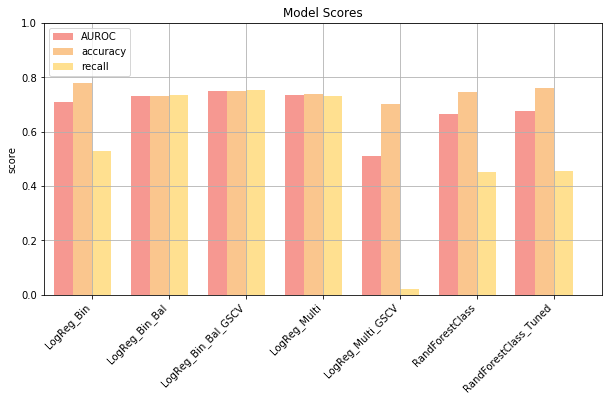

In [499]:
## h/t Chris Albon again
## https://chrisalbon.com/python/matplotlib_grouped_bar_plot.html

# Setting the positions and width for the bars
pos = list(range(len(df_scores['AUROC']))) 
width = 0.25 

# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        df_scores['AUROC'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#EE3224', 
        # with label the first value in first_name
        label=df_scores['model_name'][0]) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        df_scores['accuracy'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#F78F1E', 
        # with label the second value in first_name
        label=df_scores['model_name'][1]) 

# Create a bar with post_score data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], 
        #using df['post_score'] data,
        df_scores['recall'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#FFC222', 
        # with label the third value in first_name
        label=df_scores['model_name'][2]) 

# Set the y axis label
ax.set_ylabel('score')

# Set the chart's title
ax.set_title('Model Scores')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df_scores['model_name'],rotation = 45, ha="right")

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, 1])

# Adding the legend and showing the plot
plt.legend(['AUROC', 'accuracy', 'recall'], loc='upper left')
plt.grid()
plt.show()

This is so pretty. I'm leaving it and copying the code again to do the colors.

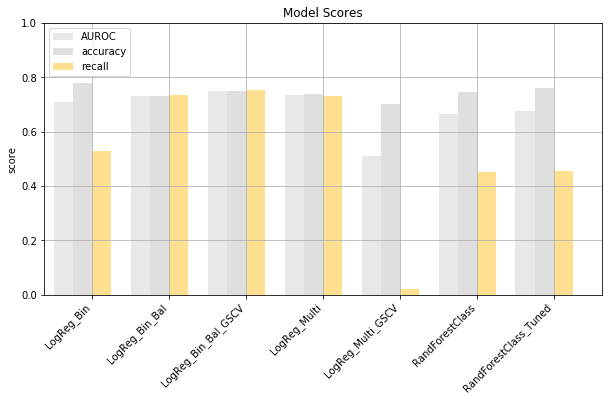

In [497]:
## h/t Chris Albon again
## https://chrisalbon.com/python/matplotlib_grouped_bar_plot.html

# Setting the positions and width for the bars
pos = list(range(len(df_scores['AUROC']))) 
width = 0.25 

# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with pre_score data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        df_scores['AUROC'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#D3D3D3', 
        # with label the first value in first_name
        label=df_scores['model_name'][0]) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        df_scores['accuracy'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#C0C0C0', 
        # with label the second value in first_name
        label=df_scores['model_name'][1]) 

# Create a bar with post_score data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], 
        #using df['post_score'] data,
        df_scores['recall'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with color
        color='#FFC222', 
        # with label the third value in first_name
        label=df_scores['model_name'][2]) 

# Set the y axis label
ax.set_ylabel('score')

# Set the chart's title
ax.set_title('Model Scores')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(df_scores['model_name'],rotation = 45, ha="right")

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*4)
plt.ylim([0, 1])

# Adding the legend and showing the plot
plt.legend(['AUROC', 'accuracy', 'recall'], loc='upper left')
plt.grid()
plt.show()

## Conclusions

See the presentation deck.